In [2]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib, sys
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
importlib.reload(sys.modules['models.ICA_EM'])
from sklearn.metrics import mean_squared_error as mse


# adjust dgp

In [20]:
class dgp():
    def __init__(self, noise_dict = {"loc" : 0, "scale" : 0}, prior = False):
        if prior:
            self.loc = prior['loc']
            self.scale = 1/np.sqrt(2)
            self.scale_confounder = prior['scale']
        else:
            self.loc = 0
            self.scale = 1/np.sqrt(2)
        self.noise = noise_dict

    def generate_data(self, n: int, I: int, J: int, random_state: int = 0,):
        np.random.seed(random_state)
       
        self._generate_dag(J)
        self._generate_coefficients_matrix(J)
        self._generate_signals(n, J)

        self._generate_mixing_matrix()

        # generate data
        self.signals = np.zeros((n, J))
        self.signals[:, 0] = self.signal_T
        self.signals[:, 1] = self.signal_Y
        self.signals[:, 2] = self.signal_U
        if self.no_controls > 0:
            self.signals[:, 3:] = self.signal_X
        self.data = np.zeros((n, J))
        for j in range(J):
            self.data[:, j] = self.mixing_matrix[j, :] @ self.signals.T

        if self.noise:
            self.data += np.random.normal(loc=self.noise['loc'], scale=self.noise["scale"], size=(n, J))
        
        # the treatment effect is in 1,0
        self.treatment_effect = self.coef_mat[1, 0]
        # observed data is missing the confounder
        obs_indices = [i for i in range(J) if i != 2]
        self.data_observed = self.data[:, obs_indices]
        self.mixing_matrix_observed = self.mixing_matrix[obs_indices, :]

    
    def _generate_dag(self, J: int):
        self.adj_matrx = np.zeros((J, J)) # adjacency matrix at least 3 nodes
        # TODO: make this more general and allow for edges between controls 
        # w.l.o.g. we can assume that the first node is the treatment and the second node is the outcome
        self.adj_matrx[0,2] = 1 # confounder -> treatment
        self.adj_matrx[1,2] = 1 # confounder -> outcome
        self.adj_matrx[1,0] = 1 # treatment -> outcome
        # build the adjacency matrix for controls
        self.no_controls = J - 3
        for i in range(3, J):
            self.adj_matrx[1, i] = 1
        
        # introduce additional edges
        if J > 3:
            self.adj_matrx[0, 3] = 1 # control -> treatment
        if J > 4:
            self.adj_matrx[4, 3] = 1 # control1 -> control
            self.adj_matrx[J-2, J-1] = 1 # control1 -> outcome



    def _generate_coefficients_matrix(self, J: int):
        coef_of_edges = np.random.uniform(low=-3, high=3, size=(J, J))
        self.coef_mat = np.multiply(self.adj_matrx, coef_of_edges) 

    def _generate_signals(self, n: int, J):
        self.signal_T = np.random.laplace(loc=self.loc, scale=self.scale, size=n)
        self.signal_Y = np.random.laplace(loc=self.loc, scale=self.scale, size=n)
        self.signal_U = np.random.laplace(loc=self.loc, scale=self.scale_confounder, size=n)
        #TODO: make this more general and with controls
        if self.no_controls > 0:
            self.signal_X = np.random.laplace(loc=self.loc, scale=self.scale, size=(n, self.no_controls))

    def _generate_mixing_matrix(self):
        # by construction, the noise has coefficient 1 for its own node
        I = np.eye(self.coef_mat.shape[0])  # Identity matrix of size J
        self.mixing_matrix =  np.linalg.inv(I - self.coef_mat)


In [3]:
n = 10000
J = 6
I = 5

In [4]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    A_0 = A[:, 0]/A[0,0]
    return A_0

In [5]:
B = 50
scale_grid = np.linspace(0.01, 2.5, 10)
treatments_true = np.zeros((len(scale_grid), B))
treatments_pred_perm = np.zeros((len(scale_grid), B))
treatments_pred_first_col = np.zeros((len(scale_grid), B))
ll_score = np.zeros((len(scale_grid), B))
mse_score = np.zeros((len(scale_grid), B))
fscore = np.zeros((len(scale_grid), B))
scale_grid


array([0.01      , 0.28666667, 0.56333333, 0.84      , 1.11666667,
       1.39333333, 1.67      , 1.94666667, 2.22333333, 2.5       ])

In [24]:
for i in tqdm.tqdm(range(len(scale_grid))):
    data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : scale_grid[i]})   
    for j in range(B):
        data.generate_data(n, I, J, random_state=j)
        est = CausalVarEM(update_sigma=False, true_A= data.mixing_matrix_observed, random_seed = j, tol=1e-4, max_iter = 100)
        est.fit(data.data_observed, J, progress_bar=False)
        treatments_true[i, j] = data.treatment_effect
        best_perm, score = f_score(data.mixing_matrix_observed, est.A)
        sorted_A = est.A[:, best_perm]
        treatments_pred_perm[i, j] = norm_funtion(sorted_A)[1]
        treatments_pred_first_col[i, j] = norm_funtion(est.A)[1]
        ll_score[i, j] = likelihood_score(data.signals, est.Signals)
        mse_score[i, j] = mean_squared_error(data.signals, est.Signals)
        fscore[i, j] = score




100%|██████████| 10/10 [3:06:59<00:00, 1121.96s/it] 


In [25]:
# save the results
for i in range(len(scale_grid)):
    df = pd.DataFrame(
        {
            "treatments_true": treatments_true[i],
            "treatments_pred_perm": treatments_pred_perm[i],
       "treatments_pred_first_col": treatments_pred_first_col[i],
            "ll_score": ll_score[i],
            "mse_score": mse_score[i],
            "fscore": fscore[i],
        }
    )
    #df.to_csv(f"results/different_scales/CausalVarEM_confounder_{scale_grid[i]}.csv", index=False)

In [6]:
# load the results 
for i in range(len(scale_grid)):
    df = pd.read_csv(f"results/different_scales/CausalVarEM_confounder_{scale_grid[i]}.csv")
    treatments_true[i] = df["treatments_true"].values
    treatments_pred_perm[i] = df["treatments_pred_perm"].values
    treatments_pred_first_col[i] = df["treatments_pred_first_col"].values
    ll_score[i] = df["ll_score"].values
    mse_score[i] = df["mse_score"].values
    fscore[i] = df["fscore"].values

Text(0, 0.5, 'Mean absolute error of the treatment effect')

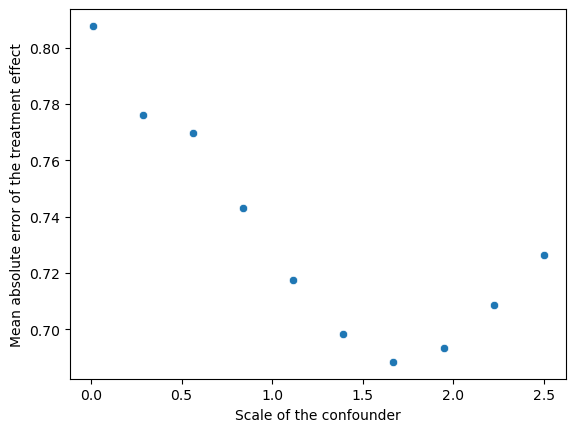

In [10]:
treatment_diff = (treatments_true - treatments_pred_first_col)
treatment_mse = np.sqrt(np.mean((treatment_diff)**2 ,axis=1))
sns.scatterplot(x=scale_grid, y=treatment_mse)
plt.xlabel("Scale of the confounder")
plt.ylabel("Mean absolute error of the treatment effect")

<Axes: >

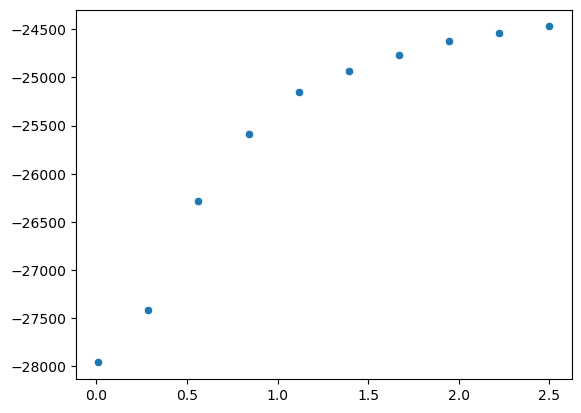

In [11]:
ll_score_mean = np.mean(ll_score, axis=1)
sns.scatterplot(x=scale_grid, y=ll_score_mean)

<Axes: >

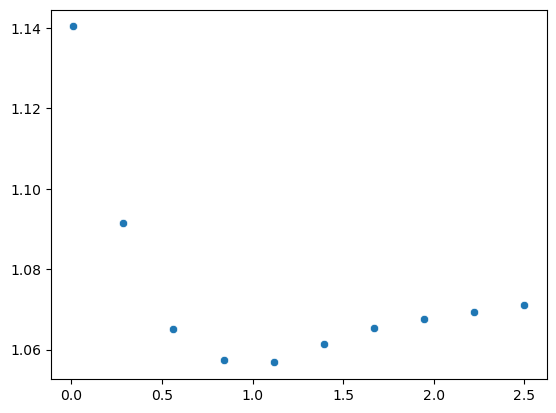

In [14]:
mse_score_mean = np.mean(mse_score, axis=1)
sns.scatterplot(x=scale_grid, y=mse_score_mean)

<Axes: >

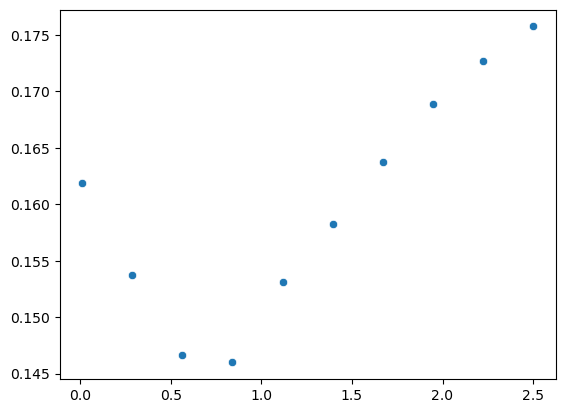

In [16]:
fscore_mean = np.mean(fscore, axis=1)
sns.scatterplot(x=scale_grid, y=fscore_mean)

Text(0.5, 1.0, 'F Score')

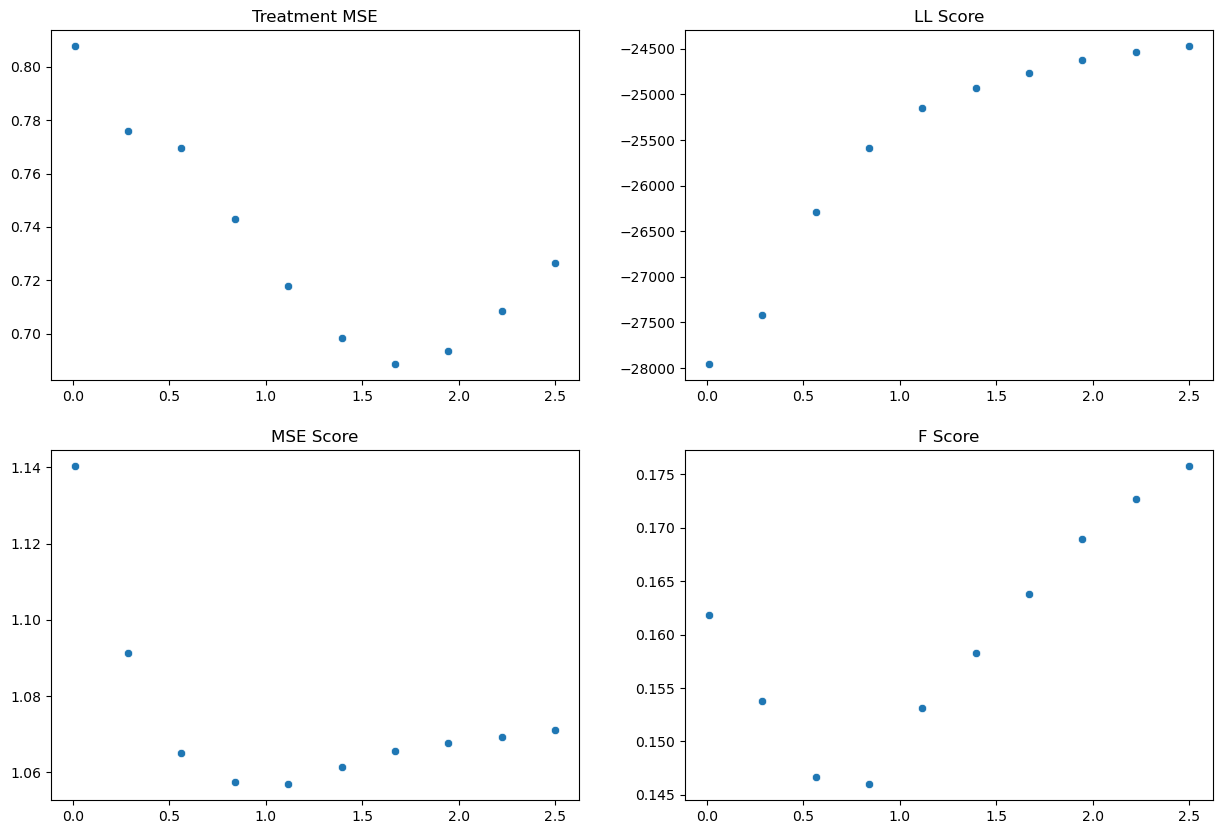

In [20]:
# plot all in one

fig, ax = plt.subplots(2, 2, figsize=(15
                                , 10))

sns.scatterplot(x=scale_grid, y=treatment_mse, ax=ax[0, 0])
ax[0, 0].set_title("Treatment MSE")
sns.scatterplot(x=scale_grid, y=ll_score_mean, ax=ax[0, 1])
ax[0, 1].set_title("LL Score")
sns.scatterplot(x=scale_grid, y=mse_score_mean, ax=ax[1, 0])
ax[1, 0].set_title("MSE Score")
sns.scatterplot(x=scale_grid, y=fscore_mean, ax=ax[1, 1])
ax[1, 1].set_title("F Score")

## plot true teatment vs predictied for different scale parameters

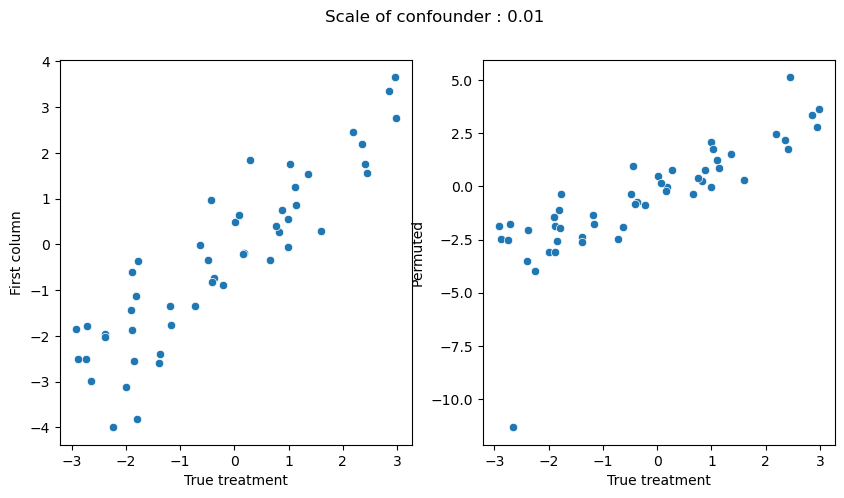

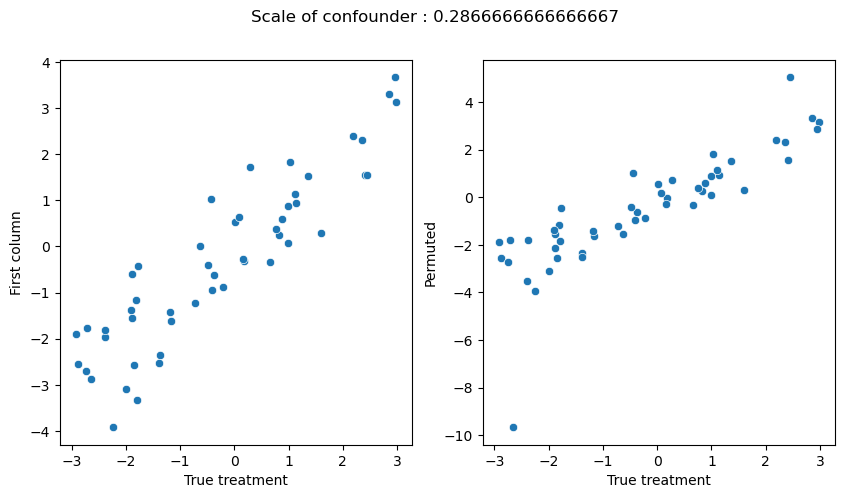

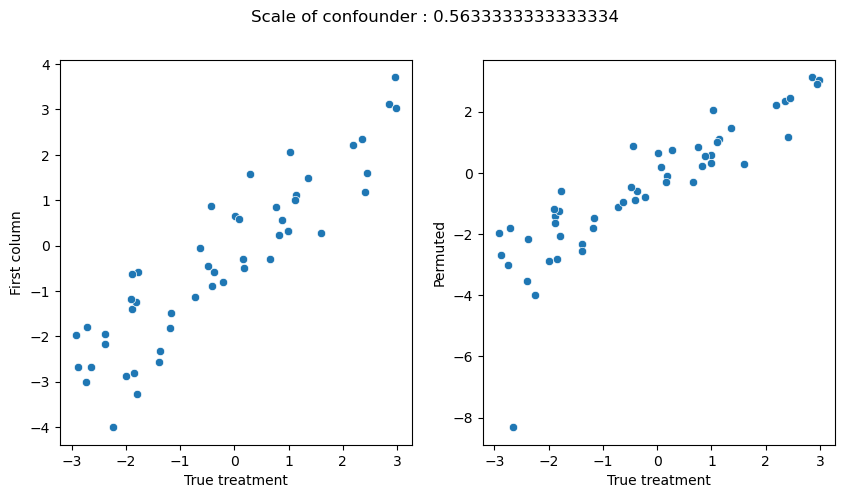

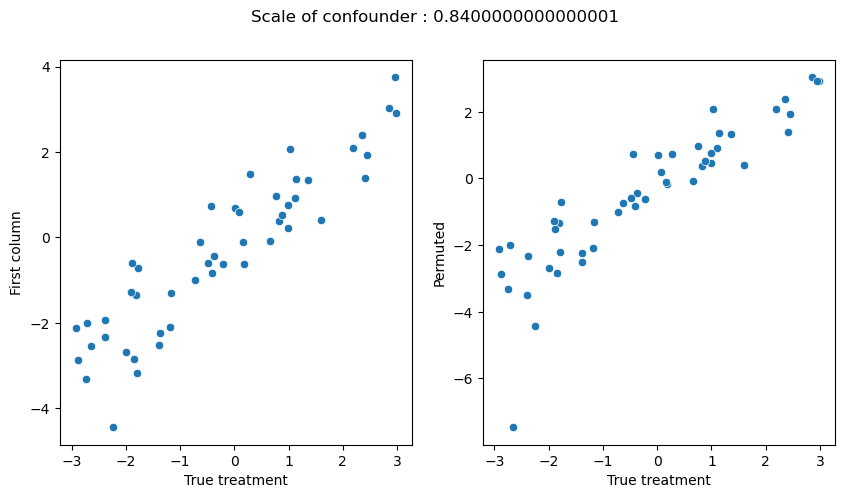

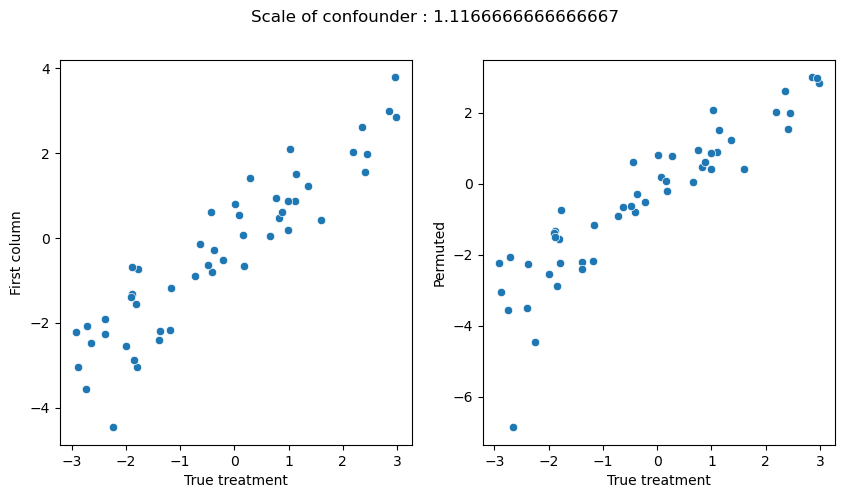

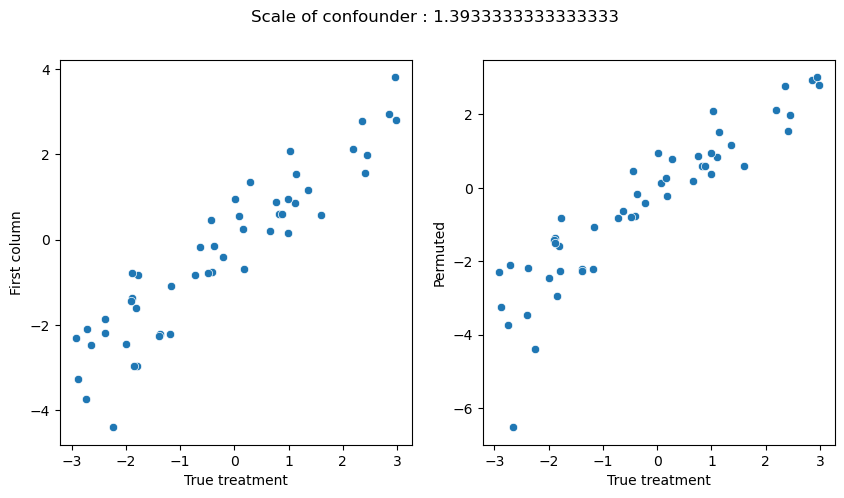

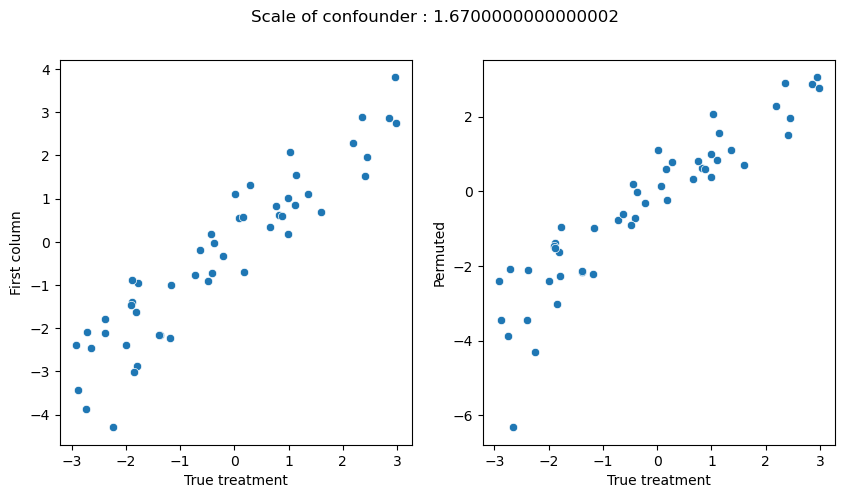

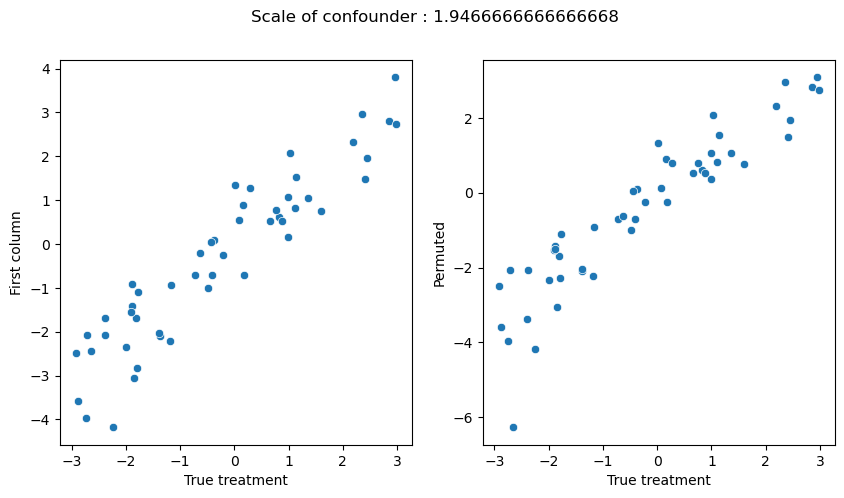

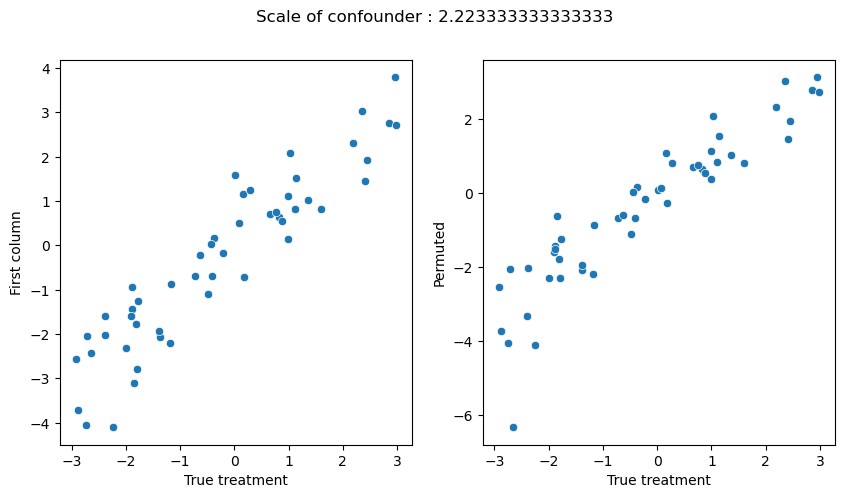

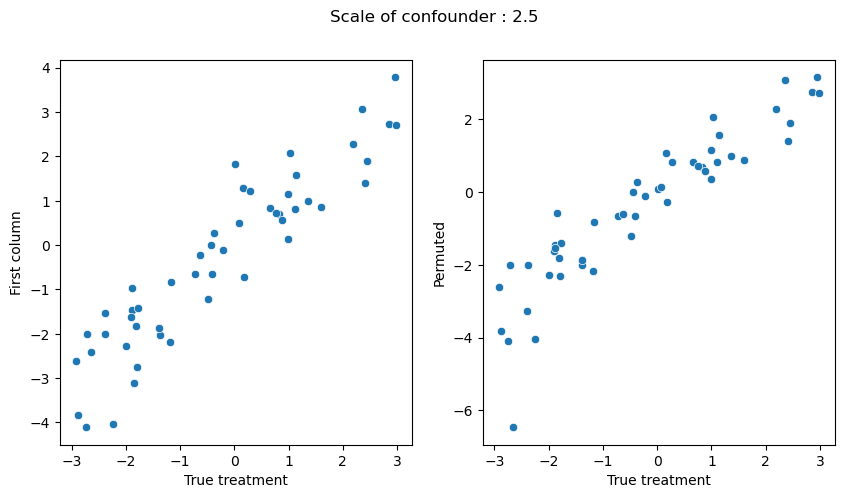

In [22]:
for i in range(len(scale_grid)):
    data = pd.read_csv(f"results/different_scales/CausalVarEM_confounder_{scale_grid[i]}.csv")
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    sns.scatterplot(x=data["treatments_true"], y=data["treatments_pred_first_col"], ax=ax[0])
    ax[0].set_ylabel("First column")
    ax[0].set_xlabel("True treatment")
    fig.suptitle(f"Scale of confounder : {scale_grid[i]}")
    sns.scatterplot(x=data["treatments_true"], y=data["treatments_pred_perm"], ax=ax[1])
    ax[1].set_ylabel("Permuted")
    ax[1].set_xlabel("True treatment")
    plt.show()



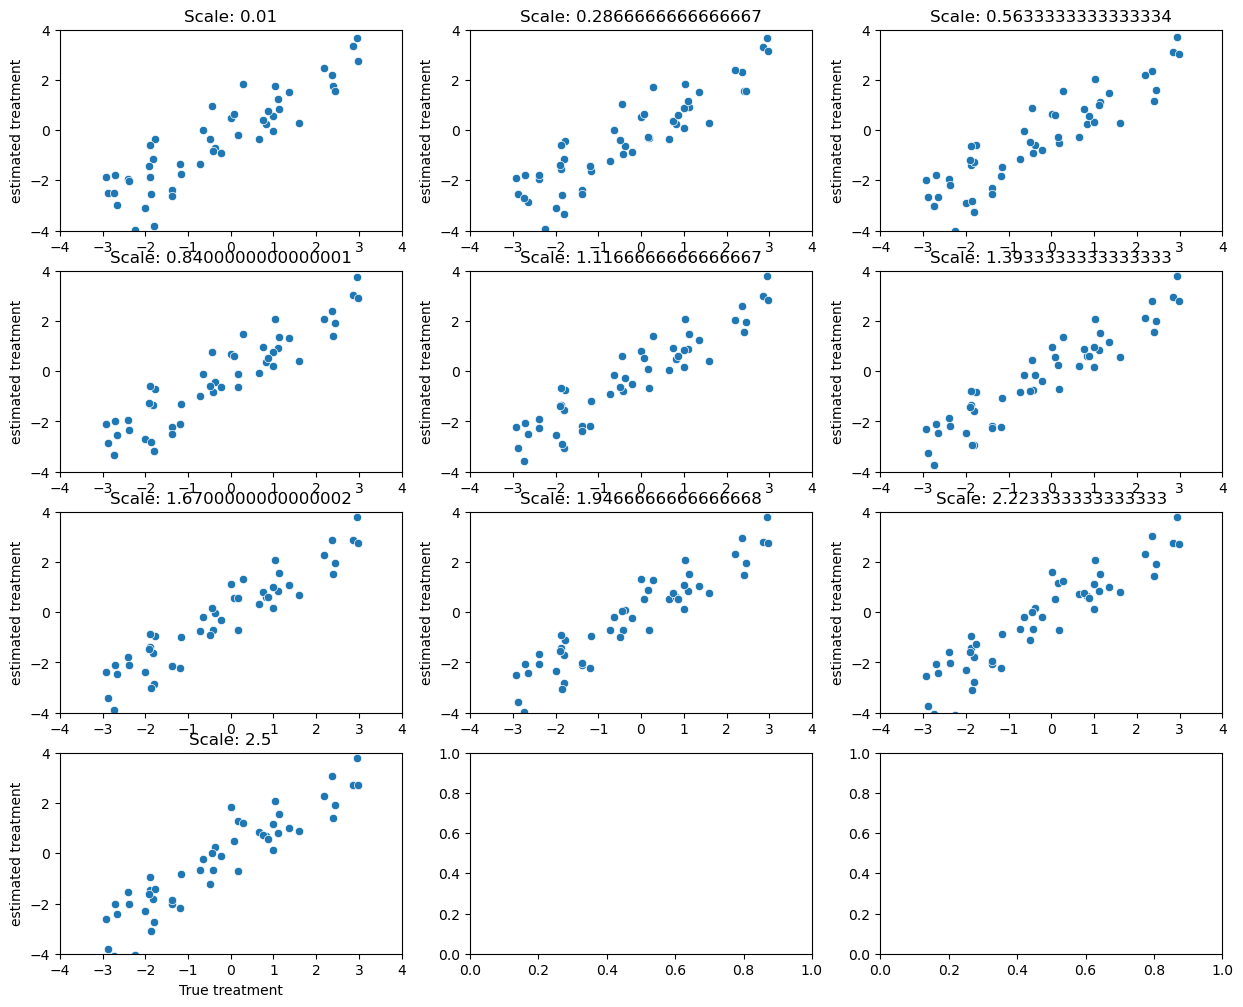

In [24]:
fig, axes = plt.subplots(4,3, figsize=(15,12 ))
axes = axes.flatten()

for i in range(len(scale_grid)):
    # Load the data
    data = pd.read_csv(f"results/different_scales/CausalVarEM_confounder_{scale_grid[i]}.csv")

    # Plot on the respective subplot
    sns.scatterplot(x=data["treatments_true"], y=data["treatments_pred_first_col"], ax=axes[i])
    axes[i].set_title(f"Scale: {scale_grid[i]}")
    if i == len(scale_grid) - 1: 
        axes[i].set_xlabel("True treatment")
    else:
        axes[i].set_xlabel("")
    axes[i].set_ylabel("estimated treatment")
    axes[i].set_ylim(-4,4)
    axes[i].set_xlim(-4,4)
